In [7]:
from sksurv.datasets import load_veterans_lung_cancer

data_x, data_y = load_veterans_lung_cancer()
data_y

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.), ( True,  42.), ( True,   8.),
       ( True, 144.), (False,  25.), ( True,  11.), ( True,  30.),
       ( True, 384.), ( True,   4.), ( True,  54.), ( True,  13.),
       (False, 123.), (False,  97.), ( True, 153.), ( True,  59.),
       ( True, 117.), ( True,  16.), ( True, 151.), ( True,  22.),
       ( True,  56.), ( True,  21.), ( True,  18.), ( True, 139.),
       ( True,  20.), ( True,  31.), ( True,  52.), ( True, 287.),
       ( True,  18.), ( True,  51.), ( True, 122.), ( True,  27.),
       ( True,  54.), ( True,   7.), ( True,  63.), ( True, 392.),
       ( True,  10.), ( True,   8.), ( True,  92.), ( True,  35.),
       ( True, 117.), ( True, 132.), ( True,  12.), ( True, 162.),
       ( True,   3.), ( True,  95.), ( True, 177.), ( True, 162.),
       ( True, 216.), ( True, 553.), ( True, 278.), ( True,  1

In [38]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')
data_x = df

# Use a compound data type for structured arrays
row_count = len(df)
data_y = np.zeros(row_count, dtype={'names':('Status', 'Survival_in_days'),
                          'formats':('?', 'f8')})
data_y['Status'] = df['status']
data_y['Survival_in_days'] = df ['time']

In [39]:
data_y

array([( True, 1814.), ( True, 2018.), ( True,  712.), ( True, 1807.),
       ( True,  772.), ( True,  448.), (False, 2172.), (False, 2161.),
       ( True,  471.), (False, 2014.), ( True,  577.), ( True,  184.),
       (False, 1840.), (False, 1842.), (False, 1821.), ( True, 1371.),
       ( True,  707.), (False, 1743.), (False, 1781.), ( True,  865.),
       ( True, 1684.), (False, 1701.), (False, 1701.), (False, 1693.),
       ( True,  379.), ( True, 1105.), ( True,  548.), ( True, 1296.),
       (False, 1483.), (False, 1570.), (False, 1469.), (False, 1472.),
       (False, 1342.), (False, 1349.), ( True, 1162.), (False, 1342.),
       ( True,  797.), (False, 1232.), (False, 1230.), (False, 1205.),
       (False, 1090.), (False, 1095.), ( True,  449.), (False,  972.),
       (False,  825.), (False, 2438.), (False, 2233.), ( True,  286.),
       (False, 1861.), ( True, 1080.), ( True, 1521.), (False, 1693.),
       ( True, 1528.), ( True,  169.), ( True,  272.), ( True,  731.),
      

In [40]:
import pandas as pd

pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

,Status,Survival_in_days
1,True,184.0
2,True,448.0
3,False,1342.0
4,False,1842.0
5,False,1693.0


Text(0.5, 0, 'time $t$')

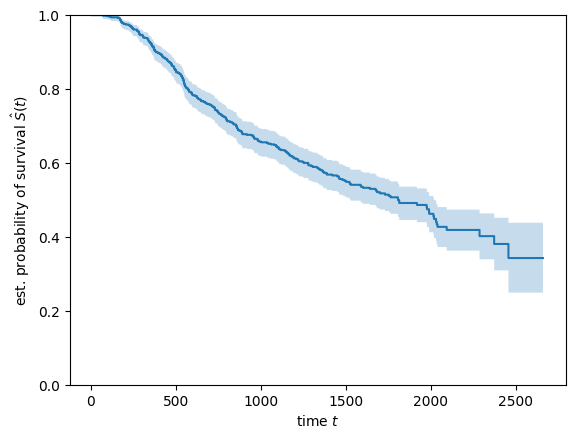

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    data_y["Status"], data_y["Survival_in_days"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [42]:
from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,id,treat,age,men,size,grade,nodes,prog,oest,time,status
0,1,0,70,2,21,2,3,48,66,1814,1
1,2,1,56,2,12,2,7,61,77,2018,1
2,3,1,58,2,35,2,9,52,271,712,1
3,4,1,59,2,17,2,4,60,29,1807,1
4,5,0,73,2,35,2,1,26,65,772,1


In [43]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

C:\Python312\Lib\site-packages\sksurv\linear_model\coxph.py:179: RuntimeWarning: divide by zero encountered in log
  loss -= (numerator - n_events * np.log(risk_set)) / n_samples
C:\Python312\Lib\site-packages\sksurv\linear_model\coxph.py:238: RuntimeWarning: invalid value encountered in divide
  z = risk_set_x / risk_set
C:\Python312\Lib\site-packages\sksurv\linear_model\coxph.py:241: RuntimeWarning: invalid value encountered in divide
  a = risk_set_xx / risk_set


ValueError: LAPACK reported an illegal value in 5-th argument.